In [14]:
from utils import make_need_tree,visualize_tree,make_storage,make_task_list,calc_start_end_time
import plotly.express as px
import pandas as pd
import json
import random
import copy
import matplotlib.pyplot as plt

In [15]:
storage = make_storage()
storage['fishing net']=20
storage['apple']=20
storage['wool']=20
storage['fish fillet']=100
tasks=make_task_list([
                      'hamburger','cheese','cookie','baked potato'
                      ],storage)
len(tasks)

52

In [16]:
# number of machines
sources={
    'Bakery':1, 'Chicken':12, 'Feed Mill':1, 'Field':50   , 'Raspberry bush':1,'Sugar Mill':1,'Cake Oven':1,
    'Cherry tree':3,'Cow':12,'BBQ Grill':1,'Dairy':1,"Pig":12,'Popcorn Pot':1,'Loom':1,'Sewing Machine':1,
    'Sheep':12,
    'Pie Oven':1,
    'Net Maker':1,
    'Fish':3
}
machines ={}
# make machines is: key is same as sources, value is a list of machine_id
# machine_id must be unique from other machines
count  = 0
for key,value in sources.items():
    machines[key]=list(range(count,count+value))
    count+=value

In [17]:
import random

def make_chromosome(tasks,machines):
    tasks = copy.deepcopy(tasks)
    random.shuffle(tasks)
    tasks.sort(key=lambda x:x['order'],reverse=True)
    for task in tasks:
        machine_id=random.choice(machines[task['source']])
        task['machine_id']=machine_id
    return tasks

def calc_fitness(chromosome):
    """calculate the fitness of a chromosome
    chromosome: a chromosome
    
    return: a fitness value
    """
    score = 0
    chromosome = calc_start_end_time(chromosome,machines)
    # maximum end_time
    max_end_time = max([task['end_time'] for task in chromosome])
    score += 10000/max_end_time
    return score
    
def mutation(chromosome):
    """mutate a chromosome
    chromosome: a chromosome
    
    return: a chromosome
    """
    chromosome = copy.deepcopy(chromosome)
    if random.random()<0.2:
        gen = random.choice(chromosome)
        new_machine_id = random.choice(machines[gen['source']])
        gen['machine_id']=new_machine_id
        
        gen1,gen2 = random.sample(chromosome,2)
        idx1 = chromosome.index(gen1)
        idx2 = chromosome.index(gen2)
        if idx1>idx2:
            gen1,gen2=gen2,gen1
        if gen1['order']>=gen2['order']:
            chromosome[idx1],chromosome[idx2]=chromosome[idx2],chromosome[idx1]
    return chromosome

def order_crossover(parent1, parent2):
    """
    Perform Order Crossover on two parent chromosomes.

    Args:
    parent1 (list): The first parent chromosome.
    parent2 (list): The second parent chromosome.

    Returns:
    tuple: A tuple containing two new child chromosomes.
    """
    size = len(parent1)
    child1, child2 = [-1] * size, [-1] * size

    # Select a random subsequence from the first parent
    start, end = sorted([random.randint(0, size - 1) for _ in range(2)])
    child1[start:end+1] = parent1[start:end+1]
    child2[start:end+1] = parent2[start:end+1]

    # Fill the remaining positions with genes from the second parent
    fill_remaining(child1, parent2, start, end)
    fill_remaining(child2, parent1, start, end)

    return child1, child2

def fill_remaining(child, parent, start, end):
    """
    Fill the remaining positions in the child chromosome.

    Args:
    child (list): The child chromosome being filled.
    parent (list): The parent chromosome to fill from.
    start (int): The start index of the subsequence.
    end (int): The end index of the subsequence.
    """
    size = len(child)
    p_idx, c_idx = 0, 0

    while -1 in child:
        if parent[p_idx] not in child:
            if c_idx >= start and c_idx <= end:
                c_idx = end + 1
            child[c_idx % size] = parent[p_idx]
            c_idx += 1
        p_idx += 1

def crossover(parent1,parent2):
    if random.random()<0.2:
        return parent1,parent2
    ids1 = [t['id'] for t in parent1]
    ids2 = [t['id'] for t in parent2]
    child1,child2 = order_crossover(ids1,ids2)
    # replace id with task
    child1 = [parent1[ids1.index(id)] for id in child1]
    child2 = [parent2[ids2.index(id)]  for id in child2]
    return child1,child2

In [18]:
# simple GA algorithm
pop_size = 60
iteration = 100

fitness_history = []
# generate inital population
population = []
for i in range(pop_size):
    population.append(make_chromosome(tasks,machines))

for i in range(iteration):
    fitness = []
    for chromosome in population:
        fitness.append(calc_fitness(chromosome))
    fitness_history.append(fitness)
    best = max(fitness)
    best_chromosome = population[fitness.index(best)]
    print(f'iteration {i}, best fitness {best}, best time {max([task["end_time"] for task in best_chromosome])}')
    # generate new population
    new_population = [best_chromosome]
    for i in range(pop_size-1):
        # select parents
        parent1,parent2 = random.choices(population,weights=fitness,k=2)
        # crossover
        child1,child2 = crossover(parent1,parent2)
        # mutation
        child1 = mutation(child1)
        child2 = mutation(child2)
        new_population.append(child1)
        new_population.append(child2)
    population = new_population[:pop_size]

iteration 0, best fitness 0.3968253968253968, best time 25200
iteration 1, best fitness 0.3968253968253968, best time 25200
iteration 2, best fitness 0.3968253968253968, best time 25200
iteration 3, best fitness 0.3968253968253968, best time 25200
iteration 4, best fitness 0.4065040650406504, best time 24600
iteration 5, best fitness 0.4065040650406504, best time 24600
iteration 6, best fitness 0.4166666666666667, best time 24000
iteration 7, best fitness 0.4166666666666667, best time 24000
iteration 8, best fitness 0.4166666666666667, best time 24000
iteration 9, best fitness 0.4166666666666667, best time 24000
iteration 10, best fitness 0.4166666666666667, best time 24000
iteration 11, best fitness 0.4166666666666667, best time 24000
iteration 12, best fitness 0.4166666666666667, best time 24000
iteration 13, best fitness 0.4166666666666667, best time 24000
iteration 14, best fitness 0.4166666666666667, best time 24000
iteration 15, best fitness 0.4166666666666667, best time 24000
it

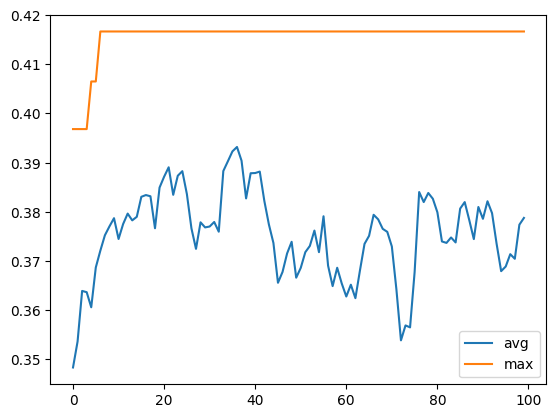

In [19]:
# plot fitness history, 2 line: average and max fitness
fitness_history = pd.DataFrame(fitness_history)
fitness_history['avg'] = fitness_history.mean(axis=1)
fitness_history['max'] = fitness_history.max(axis=1)
plt.plot(fitness_history['avg'])
plt.plot(fitness_history['max'])
plt.legend(['avg','max'])
plt.show()

In [20]:
# chromosome = make_chromosome(tasks,machines)
chromosome = population[fitness.index(max(fitness))]
test_tasks = calc_start_end_time(chromosome,machines)
df = pd.DataFrame(test_tasks)
# task is source + machine_id
df['task']=df['source']+' '+df['machine_id'].astype(str)
df['start'] = pd.to_datetime('today')+pd.to_timedelta(df['start_time'],unit='s')
df['end'] = pd.to_datetime('today')+pd.to_timedelta(df['end_time'],unit='s')
df.head()

,id,name,dependencies,duration,source,machine_id,target,order,root,start_time,end_time,task,start,end
0,4,pig feed,"[1, 2, 3]",1200,Feed Mill,13,False,3,hamburger_0,1200,2400,Feed Mill 13,2024-01-04 07:51:31.595644,2024-01-04 08:11:31.597170
1,36,soybean,[],1200,Field,43,False,5,baked potato_34,0,1200,Field 43,2024-01-04 07:31:31.595644,2024-01-04 07:51:31.597170
2,46,soybean,[],1200,Field,61,False,5,baked potato_34,0,1200,Field 61,2024-01-04 07:31:31.595644,2024-01-04 07:51:31.597170
3,45,soybean,[],1200,Field,25,False,5,baked potato_34,0,1200,Field 25,2024-01-04 07:31:31.595644,2024-01-04 07:51:31.597170
4,35,corn,[],300,Field,22,False,5,baked potato_34,0,300,Field 22,2024-01-04 07:31:31.595644,2024-01-04 07:36:31.597170


In [21]:
print("Max time: ",max(df['end_time']))
fig = px.timeline(df, x_start="start", x_end="end", y="task", color="root",hover_name='name', 
                    hover_data={'id':True,'duration':True,'start':False,'end':False,'task':False,'name':False,'source':False,'machine_id':False,'dependencies':True})
fig.update_yaxes(autorange="reversed")
fig.show()
#36300

Max time:  24000
